### Testing notebook to prototype exposure custom options

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


## Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Temp for tide model testing 17/07/23
from dea_tools.coastal import model_tides, pixel_tides


!pip install sunriset

## Setup
### Set analysis parameters

In [4]:
# Set study area and config
study_area = "pointstuart"
config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '844'
# config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 100  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2014"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models"#"/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
# tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*

In [5]:
# from odc.ui import select_on_a_map
# from ipyleaflet import basemaps, basemap_to_tiles

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height='600px',
#                        layers=(basemap,),
#                        center=(-26, 135),
#                        zoom=4)
# study_area = geom

## Intertidal workflow
#### Load data

In [6]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    s2_prod="s2_nbart_ndwi" if include_s2 else None,
    ls_prod="ls_nbart_ndwi" if include_ls else None,
    config_path=config_path,
    filter_gqa=filter_gqa)[["ndwi"]]

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45649,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:46043,Total threads: 31
Dashboard: /user/claire.phillips@ga.gov.au/proxy/40461/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:32821,


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [7]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [8]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    config_path=config_path,
)

2023-07-21 03:41:25 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Reprojecting tides into original array


100%|██████████| 329/329 [00:00<00:00, 1676.72it/s]
2023-07-21 03:42:27 INFO Masking nodata and adding tide heights to satellite data array
INFO:DEA Intertidal:Masking nodata and adding tide heights to satellite data array
2023-07-21 03:42:27 INFO Flattening satellite data array and filtering to intertidal candidate pixels
INFO:DEA Intertidal:Flattening satellite data array and filtering to intertidal candidate pixels
2023-07-21 03:42:27 INFO Applying valid data mask to constrain study area
INFO:DEA Intertidal:Applying valid data mask to constrain study area
2023-07-21 03:42:27 INFO Running per-pixel rolling median
INFO:DEA Intertidal:Running per-pixel rolling median


Reducing analysed pixels from 759 to 483 (63.64%)


100%|██████████| 114/114 [00:00<00:00, 441.46it/s]
2023-07-21 03:42:28 INFO Modelling intertidal elevation
INFO:DEA Intertidal:Modelling intertidal elevation
2023-07-21 03:42:28 INFO Modelling intertidal uncertainty
INFO:DEA Intertidal:Modelling intertidal uncertainty
2023-07-21 03:42:28 INFO Unflattening data back to its original spatial dimensions
INFO:DEA Intertidal:Unflattening data back to its original spatial dimensions
2023-07-21 03:42:28 INFO Successfully completed intertidal elevation modelling
INFO:DEA Intertidal:Successfully completed intertidal elevation modelling


### Intertidal extents

In [9]:
ds['extents'] = extents(ds_aux.ndwi_wet_freq, ds.elevation, ds_aux.ndwi_tide_corr)

### Intertidal exposure
Calculate exposure using the script function

In [ ]:
ds["exposure"], tide_cq, _ = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

In [ ]:
tide_cq.plot()

In [ ]:
## Testing updated script

%reload_ext autoreload

ds["exposure_summer"], tide_cq_summer, tiderange_summer = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters = ['summer']
)

In [ ]:
## Testing cell

## Bring in the geodata coast 100K polygons to assign local timezones to pixels

import geopandas as gpd
import xarray as xr

from shapely.geometry import Point
from shapely.ops import unary_union
import sunriset
from math import ceil
import datetime
from datetime import timedelta
import pytz
from pyproj import CRS
from pyproj import Transformer



In [11]:
timezones = {'wa':'../../gdata1/data/boundaries/GEODATA_COAST_100K/western_australia/cstwacd_r.shp',
                 'nt':'../../gdata1/data/boundaries/GEODATA_COAST_100K/northern_territory/cstntcd_r.shp',
                 'sa':'../../gdata1/data/boundaries/GEODATA_COAST_100K/south_australia/cstsacd_r.shp',
                 'qld':'../../gdata1/data/boundaries/GEODATA_COAST_100K/queensland/cstqldmd_r.shp',
                 'nsw':'../../gdata1/data/boundaries/GEODATA_COAST_100K/new_south_wales/cstnswcd_r.shp',
                 'vic':'../../gdata1/data/boundaries/GEODATA_COAST_100K/victoria/cstviccd_r.shp',
                 'tas':'../../gdata1/data/boundaries/GEODATA_COAST_100K/tasmania/csttascd_r.shp'
            }
timezones['wa']

'../../gdata1/data/boundaries/GEODATA_COAST_100K/western_australia/cstwacd_r.shp'

In [ ]:
## Bring in the state polygons (note: native crs = epsg:4283)
wa = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/western_australia/cstwacd_r.shp')
nt = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/northern_territory/cstntcd_r.shp')
sa = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/south_australia/cstsacd_r.shp')
qld = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/queensland/cstqldmd_r.shp')
nsw = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/new_south_wales/cstnswcd_r.shp')
vic = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/victoria/cstviccd_r.shp')
tas = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/tasmania/csttascd_r.shp')

# Merge to create single timezone (state) boundaries
wa = gpd.GeoSeries(unary_union(wa.geometry))
nt = gpd.GeoSeries(unary_union(nt.geometry))
sa = gpd.GeoSeries(unary_union(sa.geometry))
qld = gpd.GeoSeries(unary_union(qld.geometry))
nsw = gpd.GeoSeries(unary_union(nsw.geometry))
vic = gpd.GeoSeries(unary_union(vic.geometry))
tas = gpd.GeoSeries(unary_union(tas.geometry))

In [ ]:
## Transform the analysis aoi coords to common CRS

tidepost_lat_3577 = ds.x.median(dim='x').values
tidepost_lon_3577 = ds.y.median(dim='y').values

## Datacube native CRS
crs_3577 = CRS.from_epsg(3577) 

## GDA94/Aus Albers (meters)

## Create a transform to convert default epsg3577 coords to epsg4326 for use in sunise/sunset library

## World WGS84 (degrees)
crs_4326 = CRS.from_epsg(4326) 
## Transfer coords from/to
transformer_4326 = Transformer.from_crs(crs_3577, crs_4326)
## Translate the tidepost coords
tidepost_lat_4326, tidepost_lon_4326 = transformer_4326.transform(tidepost_lat_3577, tidepost_lon_3577)
## Coordinate point to locate the sunriset calculation
point_4326 = Point(tidepost_lon_4326, tidepost_lat_4326)

## (1) Create a transform to convert default epsg3577 coords to epsg4283 to compare against polygons and 
## assign a timezone

## GDA94 CRS (degrees)
crs_4283 = CRS.from_epsg(4283) ## GDA94 Australia (degrees)
## Transfer coords from/to
transformer_4283 = Transformer.from_crs(crs_3577, crs_4283) 
## Translate tidepost coords
tidepost_lat_4283, tidepost_lon_4283 = transformer_4283.transform(tidepost_lat_3577, tidepost_lon_3577)
## Coordinate point to test for timezone   
point_4283 = Point(tidepost_lon_4283, tidepost_lat_4283)


In [ ]:
## Set the local timezone for the analysis area of interest
if wa.contains(point_4283)[0] == True:
    timezone = 'Australia/West'
    local_tz = 8
    # break
elif nt.contains(point_4283)[0] == True:
    timezone = 'Australia/North'
    local_tz = 9.5
    # break
elif sa.contains(point_4283)[0] == True:
    timezone = 'Australia/South'
    local_tz = 9.5
    # break
elif qld.contains(point_4283)[0] == True:
    timezone = 'Australia/Queensland'
    local_tz = 10
    # break
elif nsw.contains(point_4283)[0] == True:
    timezone = 'Australia/NSW'
    local_tz = 10
    # break
elif vic.contains(point_4283)[0] == True:
    timezone = 'Australia/Victoria'
    local_tz = 10
    # break
elif tas.contains(point_4283)[0] == True:
    timezone = 'Australia/Tasmania'
    local_tz = 10
    # break
print (timezone, local_tz)    

In [ ]:
!pip install sunriset

In [ ]:
## Testing sunriset calculations

# Place start and end dates in correct format
start=round_date_strings(start_date, round_type="start")
end=round_date_strings(end_date, round_type="end")
startdate = datetime.date(pd.to_datetime(start).year, pd.to_datetime(start).month, pd.to_datetime(start).day)

# # Make the start date timezone aware 
# time_start = pd.to_datetime(start, utc=True).tz_convert(timezone)

# Make 'all_timerange' time-zone aware
localtides = all_timerange.tz_localize(tz=pytz.UTC).tz_convert(timezone)

# Replace the UTC datetimes from all_timerange with local times
modelledtides = pd.DataFrame(index = localtides)

# Return the difference in years for the time-period. 
# Round up to ensure all modelledtide datetimes are captured in the solar model
diff = pd.to_datetime(end) - pd.to_datetime(start)
diff = int(ceil(diff.days/365))

# ## Locate the central pixel for the area of interest
# ## TODO: work out how to manage this in the pixel-based workflow. Perhaps
# ## use the same modelling resolution as the underlying tidal model?
# tidepost_lat = ds.x.median(dim='x')
# tidepost_lon = ds.y.median(dim='y')

# ## Create a transform to convert default epsg3577 coords to epsg4326 for use in sunise/sunset library
# crs_4326 = CRS.from_epsg(4326)
# crs_3577 = CRS.from_epsg(3577)

# transformer = Transformer.from_crs(crs_3577, crs_4326)

# ## Translate tidepost coords
# tidepost_lat, tidepost_lon = transformer.transform(tidepost_lon.values, tidepost_lat.values)

## Model sunrise and sunset
sun_df = sunriset.to_pandas(startdate, tidepost_lat_4326, tidepost_lon_4326, local_tz, diff)

## Set the index as a datetimeindex to match the modelledtide df
sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))

## Append the date to each Sunrise and Sunset time
sun_df['Sunrise dt'] = sun_df.index + sun_df['Sunrise']
sun_df['Sunset dt'] = sun_df.index + (sun_df['Sunset'])

## Create new dataframes where daytime and nightime datetimes are recorded, then merged on a new `Sunlight` column
daytime=pd.DataFrame(data = 'Sunrise', index=sun_df['Sunrise dt'], columns=['Sunlight'])
nighttime=pd.DataFrame(data = 'Sunset', index=sun_df['Sunset dt'], columns=['Sunlight'])
DayNight = pd.concat([daytime, nighttime], join='outer')
DayNight.sort_index(inplace=True)
DayNight.index.rename('Datetime', inplace=True)

## Create an xarray object from the merged day/night dataframe
day_night = xr.Dataset.from_dataframe(DayNight)

## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
## timezone aware datetimeindexes 'from_dataframe' very well.
modelledtides.index = modelledtides.index.tz_localize(tz=None)

## Create an xr Dataset from the modelledtides pd.dataframe
mt = modelledtides.to_xarray()

## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
## Modelled tides are designated as either day or night by propogation of the last valid index value forward
Solar=day_night.sel(Datetime=mt.index, method='ffill')

## Assign the day and night tideheight datasets
SolarDayTides = mt.where(Solar.Sunlight=='Sunrise', drop=True)
SolarNightTides = mt.where(Solar.Sunlight=='Sunset', drop=True)

## Extract DatetimeIndexes to use in exposure calculations
all_timerange_day = pd.DatetimeIndex(SolarDayTides.index)
all_timerange_night = pd.DatetimeIndex(SolarNightTides.index)



In [18]:
%reload_ext autoreload

ds["exposure_daylight"], tide_cq_day, tiderange_day = exposure(
    start_date,
    end_date,
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters = ['Daylight'],
    timezones=timezones
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:00<00:00, 1133.87it/s]


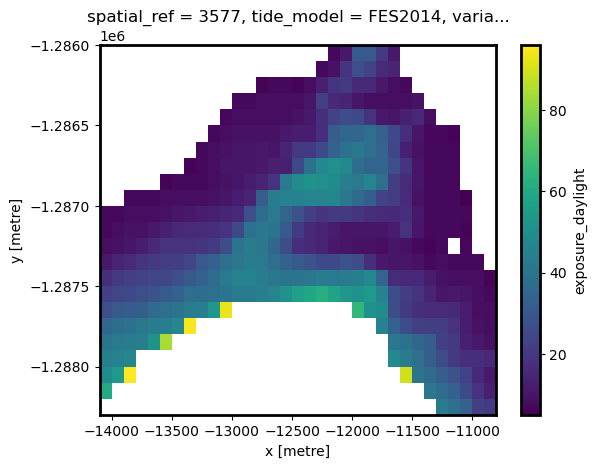

In [19]:
ds.exposure_daylight.plot()

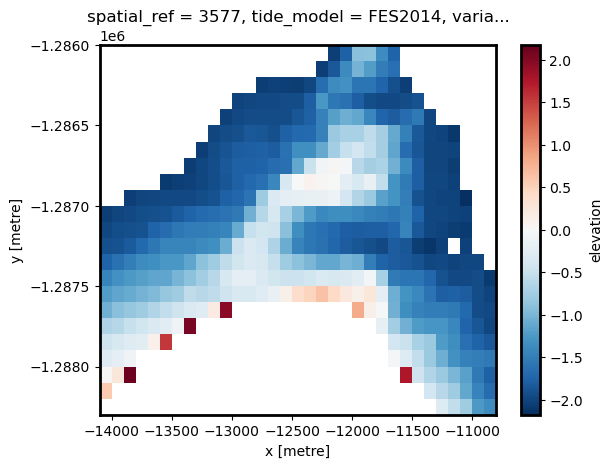

In [20]:
ds.elevation.plot()

In [33]:
from dea_tools.coastal import model_tides, pixel_tides

In [65]:
?pixel_tides

Signature:
pixel_tides(
    ds,
    times=None,
    resample=True,
    calculate_quantiles=None,
    resolution=None,
    buffer=None,
    resample_method='bilinear',
    model='FES2014',
    **model_tides_kwargs,
)
Docstring:
Obtain tide heights for each pixel in a dataset by modelling
tides into a low-resolution grid surrounding the dataset,
then (optionally) spatially resample this low-res data back
into the original higher resolution dataset extent and resolution.

Parameters:
-----------
ds : xarray.Dataset
    A dataset whose geobox (`ds.odc.geobox`) will be used to define
    the spatial extent of the low resolution tide modelling grid.
times : pandas.DatetimeIndex or list of pandas.Timestamps, optional
    By default, the function will model tides using the times
    contained in the `time` dimension of `ds`. Alternatively, this
    param can be used to model tides for a custom set of times
    instead. For example:
    `times=pd.date_range(start="2000", end="2001", freq="5h")`

In [36]:
## Testing for spatial customisation (splicing up the tidal zone)

modelledtides = pixel_tides(
                ds,
                times=all_timerange,
                model=tide_model,
                directory = '../../gdata1/data/tide_models')
    

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Reprojecting tides into original array


100%|██████████| 8761/8761 [00:04<00:00, 1767.50it/s]


In [73]:
from scipy.signal import argrelmax 
from scipy.signal import argrelmin 
from scipy.interpolate import interp1d 
import xarray as xr

In [97]:
# mt_df = modelledtides[0].to_dataframe()#.(dim='time') ##high_res tides

In [130]:
# ## All peaks(maxima) in modelledtides 
# # Max = argrelmax(modelledtides[0:-1].tideheights.values)
# mt_df['Max'] = argrelmax(mt_df.tide_m.values)[0]

# # def tide_maxima(first_sample, dim):
# #     return xr.apply_ufunc(argrelmax,
# #                        first_sample,
# #                        input_core_dims=dim,
# #                        # output_core_dims=[['y'],['x']],
# #                        vectorize=False)

# # test = tide_maxima(modelledtides[0].values, dim=[[],['y'],['x']])
# # test




# # Max = np.array(Max[0])

# mt_df

In [110]:
argrelmax(modelledtides[0].isel(y=1,x=1).values)

(array([   2,    6,   11, ..., 8750, 8754, 8758]),)

In [121]:
Max_test = np.array(argrelmax(modelledtides[0].isel(y=1,x=1).values)[0])
Max_test

array([   2,    6,   11, ..., 8750, 8754, 8758])

In [134]:
test_mt = modelledtides[0].isel(y=1,x=1)

In [138]:
test_selection1 = test_mt[Max_test]
test_selection1.values

array([1.3114041, 1.5426903, 1.3786919, ..., 1.5512965, 1.3487471,
       1.4019824], dtype=float32)

In [139]:
#Find the maxima (spring high) of the maxima
maxhigh = argrelmax(test_selection1.values)
maxhigh = np.array(maxhigh[0])
springhigh = argrelmax(test_mt[maxhigh].values)
springhigh = np.array(springhigh[0])

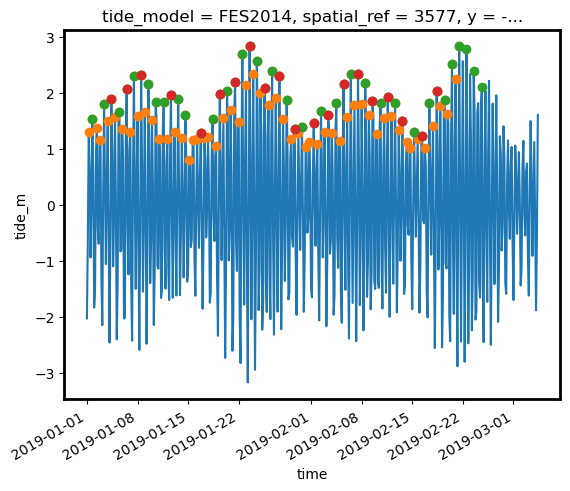

In [157]:
modelledtides[0].isel(y=1,x=1)[0:500].plot()
test_mt[Max_test][0:100].plot(marker='o', linestyle='')    
test_mt[Max_test][maxhigh][0:50].plot(marker='o', linestyle='')
test_mt[Max_test][maxhigh][springhigh][0:20].plot(marker='o', linestyle='')

In [37]:
## Original code prototype

 ## Find all spring and neap high tides

            ## All peaks(maxima) in modelledtides 
            Max = argrelmax(modelledtides[0:-1].tideheights.values)
            Max = np.array(Max[0])

            ## Find higher tides in the maxima then the spring high tides 
            maxhigh = argrelmax(modelledtides.tideheights[Max].values)
            maxhigh = np.array(maxhigh[0])
            springhigh = argrelmax(modelledtides.tideheights[Max[maxhigh]].values)
            springhigh = np.array(springhigh[0]) 

            ## Find lower tides in the maxima then the neap high tides
            maxlow = argrelmin(modelledtides.tideheights[Max].values)
            maxlow = np.array(maxlow[0])
            neaphigh = argrelmin(modelledtides.tideheights[Max[maxlow]].values)
            neaphigh = np.array(neaphigh[0])

            ## Repeat to determine spring and neap low tides.

            ## All minima in modelledtides 
            Min = argrelmin(modelledtides[0:-1].tideheights.values)
            Min = np.array(Min[0])

            ## Find higher tides in the maxima then the spring high tides 
            minhigh = argrelmin(modelledtides.tideheights[Min].values)
            minhigh = np.array(minhigh[0])
            springlow = argrelmin(modelledtides.tideheights[Min[minhigh]].values)
            springlow = np.array(springlow[0])

            ## Find lower tides in the maxima then the neap high tides
            minlow = argrelmax(modelledtides.tideheights[Min].values)
            minlow = np.array(minlow[0])
            neaplow = argrelmax(modelledtides.tideheights[Min[minlow]].values)
            neaplow = np.array(neaplow[0])

            # Add column to modelledtides to plot without using datetime values
            modelledtides['count'] = np.arange(0,len(modelledtides),1)

            ## Interpolate the high and low spring and neap curves
            neap_high_linear = interp1d(Max[maxlow], modelledtides.tideheights[Max[maxlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['neap_high_interp'] = neap_high_linear(modelledtides['count'])

            spring_high_linear = interp1d(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['spring_high_interp'] = spring_high_linear(modelledtides['count'])

            neap_low_linear = interp1d(Min[minlow], modelledtides.tideheights[Min[minlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['neap_low_interp'] = neap_low_linear(modelledtides['count'])

            spring_low_linear = interp1d(Min[minhigh], modelledtides.tideheights[Min[minhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['spring_low_interp'] = spring_low_linear(modelledtides['count'])

            ## Extract datetimeindex for each dataslice
            spring_high = modelledtides.tideheights[Max[maxhigh[springhigh]]].index
            spring_low = modelledtides.tideheights[Min[minhigh[springlow]]].index
            neap_high = modelledtides.tideheights[Max[maxlow[neaphigh]]].index
            neap_low = modelledtides.tideheights[Min[minlow[neaplow]]].index
            hightide = modelledtides[modelledtides.tideheights > modelledtides.neap_high_interp].index
            lowtide = modelledtides[modelledtides.tideheights < modelledtides.neap_low_interp].index

                            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in hightide.array)
            filteredtides['timerange'] = hightide
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters['hightide'] = filteredtides
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in lowtide.array)
            filteredtides['timerange'] = lowtide
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters['lowtide'] = filteredtides

(<xarray.DataArray 'tide_m' (time: 8761, y: 23, x: 33)>
 array([[[-2.0278747 , -2.0280788 , -2.0282829 , ..., -2.0345905 ,
          -2.0348356 , -2.0350804 ],
         [-2.0279999 , -2.0282042 , -2.0284085 , ..., -2.0346997 ,
          -2.0349433 , -2.0351868 ],
         [-2.028125  , -2.0283296 , -2.0285344 , ..., -2.0348089 ,
          -2.035051  , -2.035293  ],
         ...,
         [-2.0300355 , -2.0302496 , -2.0304637 , ..., -2.0364347 ,
          -2.0366473 , -2.0368598 ],
         [-2.0300987 , -2.0303137 , -2.0305288 , ..., -2.036482  ,
          -2.0366924 , -2.036903  ],
         [-2.0301616 , -2.0303776 , -2.0305936 , ..., -2.0365295 ,
          -2.0367377 , -2.036946  ]],
 
        [[-0.6049201 , -0.60547054, -0.6060209 , ..., -0.6200133 ,
          -0.6204658 , -0.62091833],
         [-0.60533094, -0.6058837 , -0.60643643, ..., -0.6204746 ,
          -0.6209281 , -0.62138164],
         [-0.6057418 , -0.6062969 , -0.606852  , ..., -0.62093586,
          -0.6213904 , -0.62